# IREP: registre des émissions polluantes

Ce jeu de données est disponible sous le nombre [Registre des émissions polluantes](http://www.georisques.gouv.fr/dossiers/irep/telechargement).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Récupération des données

Les données ont été préalablement téléchargées et zippées.

In [3]:
from ensae_teaching_cs.data import load_irep
load_irep()

['.\\2003/emissions.csv',
 '.\\2003/etablissements.csv',
 '.\\2003/Prelevements.csv',
 '.\\2003/Prod_dechets_dangereux.csv',
 '.\\2003/Prod_dechets_non_dangereux.csv',
 '.\\2003/Trait_dechets_dangereux.csv',
 '.\\2003/Trait_dechets_non_dangereux.csv',
 '.\\2004/emissions.csv',
 '.\\2004/etablissements.csv',
 '.\\2004/Prelevements.csv',
 '.\\2004/Prod_dechets_dangereux.csv',
 '.\\2004/Prod_dechets_non_dangereux.csv',
 '.\\2004/Trait_dechets_dangereux.csv',
 '.\\2004/Trait_dechets_non_dangereux.csv',
 '.\\2005/emissions.csv',
 '.\\2005/etablissements.csv',
 '.\\2005/Prelevements.csv',
 '.\\2005/Prod_dechets_dangereux.csv',
 '.\\2005/Prod_dechets_non_dangereux.csv',
 '.\\2005/Trait_dechets_dangereux.csv',
 '.\\2005/Trait_dechets_non_dangereux.csv',
 '.\\2006/emissions.csv',
 '.\\2006/etablissements.csv',
 '.\\2006/Prelevements.csv',
 '.\\2006/Prod_dechets_dangereux.csv',
 '.\\2006/Prod_dechets_non_dangereux.csv',
 '.\\2006/Trait_dechets_dangereux.csv',
 '.\\2006/Trait_dechets_non_dangereu

In [4]:
import pandas
df = pandas.read_csv("2017/Prod_dechets_dangereux.csv")
df.head()

,Identifiant,Nom_Etablissement,Dechet,Annee,Code_Operation_Eliminatio_Valorisation,Libelle_Operation_Eliminatio_Valorisation,Code_Departement,Pays,Code_Dechet,Libelle_Dechet,Quantite,Unite
0,31.02589,POLYPROCESS,Production de dÃ©chets dangereux,2017,D13,D13 Regroupement préalablement à l'une des opé...,33,NaN,16 03 03*,Déchets d'origine minérale contenant des subst...,2.320,t/an
1,31.02589,POLYPROCESS,Production de dÃ©chets dangereux,2017,D8,D8 Traitement biologique non spécifié ailleurs...,64,NaN,13 05 07*,Eau mélangée à des hydrocarbures provenant de ...,1.500,t/an
2,31.02589,POLYPROCESS,Production de dÃ©chets dangereux,2017,R12,R12 Echange de déchets en vue de les soumettre...,16,NaN,13 05 02*,Boues provenant de séparateurs eau/hydrocarbures,0.500,t/an
3,31.02589,POLYPROCESS,Production de dÃ©chets dangereux,2017,R13,R13 Stockage de déchets préalablement à l'une ...,33,NaN,06 10 02*,Déchets contenant des substances dangereuses,0.103,t/an
4,31.02589,POLYPROCESS,Production de dÃ©chets dangereux,2017,R13,R13 Stockage de déchets préalablement à l'une ...,33,NaN,15 01 10*,Emballages contenant des résidus de substances...,2.400,t/an


In [5]:
[_ for _ in set(df.Nom_Etablissement) if "lubrizol" in _.lower()]

['LUBRIZOL France Site de Rouen (siège social et usine)',
 'LUBRIZOL FRANCE',
 'LUBRIZOL France']

In [6]:
df[df.Nom_Etablissement.str.contains("LUBRI")].head().T

,5073,5074,5075,5076,19092
Identifiant,52.0271,52.0271,52.0271,52.0271,58.0057
Nom_Etablissement,LUBRIZOL FRANCE,LUBRIZOL FRANCE,LUBRIZOL FRANCE,LUBRIZOL FRANCE,LUBRIZOL France Site de Rouen (siège social et...
Dechet,Production de dÃ©chets dangereux,Production de dÃ©chets dangereux,Production de dÃ©chets dangereux,Production de dÃ©chets dangereux,Production de dÃ©chets dangereux
Annee,2017,2017,2017,2017,2017
Code_Operation_Eliminatio_Valorisation,D10,D5,D8,R12,D10
Libelle_Operation_Eliminatio_Valorisation,D10 Incinération à terre,D5 Mise en décharge spécialement aménagée (par...,D8 Traitement biologique non spécifié ailleurs...,R12 Echange de déchets en vue de les soumettre...,D10 Incinération à terre
Code_Departement,01,30,64,34,76
Pays,NaN,NaN,NaN,NaN,NaN
Code_Dechet,07 01 01*,17 02 04*,07 07 01*,15 02 02*,07 01 04*
Libelle_Dechet,Eaux de lavage et liqueurs mères aqueuses,"Bois, verre et matières plastiques contenant d...",Eaux de lavage et liqueurs mères aqueuses,"Absorbants, matériaux filtrants (y compris les...","Autres solvants, liquides de lavage et liqueur..."


In [7]:
ets = pandas.read_csv("2017/etablissements.csv")
ets.head()

,Identifiant,Nom_Etablissement,Numero_SIRET,Adresse,Code_Postal,Commune,Departement,Region,Coordonnees_X,Coordonnees_Y,Code_APE,Libelle_APE,code_eprtr,libelle_eprtr
0,68.11539,Carrières BERNADETS - ISDI,54608016900115,NaN,31420,AURIGNAC,HAUTE-GARONNE,OCCITANIE,481659.0,1802490.0,0812Z,"Exploitation de gravières et sablières, extrac...",NaN,NaN
1,61.10406,REVAGA,51058711600037,NaN,69390,MILLERY,RHONE,AUVERGNE-RHONE-ALPES,790678.0,2073093.0,3811Z,Collecte des déchets non dangereux,NaN,NaN
2,124.00155,SATE,42976802100025,NaN,90150,FONTAINE,TERRITOIRE-DE-BELFORT,BOURGOGNE-FRANCHE-COMTE,949818.0,2305514.0,2751Z,Fabrication d'appareils électroménagers,NaN,NaN
3,61.08347,GRTgaz - Station de Compression de St AVIT,44011762001571,NaN,26330,CHATEAUNEUF-DE-GALAURE,DROME,AUVERGNE-RHONE-ALPES,805789.0,2028946.0,4950Z,Transports par conduites,NaN,NaN
4,61.10271,FONDEX SAS,60562013700030,NaN,74302,CLUSES,HAUTE-SAVOIE,AUVERGNE-RHONE-ALPES,928249.0,2126191.0,2550B,"Découpage, emboutissage",NaN,NaN


In [8]:
ets[ets.Nom_Etablissement.str.contains("LUBRI")]

,Identifiant,Nom_Etablissement,Numero_SIRET,Adresse,Code_Postal,Commune,Departement,Region,Coordonnees_X,Coordonnees_Y,Code_APE,Libelle_APE,code_eprtr,libelle_eprtr
5696,52.02708,LUBRIZOL FRANCE,54207095800047,Pôle 4/RD 281 avenue du Lac,64150,MOURENX,PYRENEES-ATLANTIQUES,NOUVELLE-AQUITAINE,359197.0,1823064.0,2059Z,Fabrication d'autres produits chimiques n.c.a.,4.(a).(iii),hydrocarbures sulfurés
6147,58.00574,LUBRIZOL France Site de Rouen (siège social et...,54207095800021,"25, Quai de France BP 1062",76173,ROUEN,SEINE-MARITIME,NORMANDIE,509411.0,2494315.0,2059Z,Fabrication d'autres produits chimiques n.c.a.,4.(a).(iii),hydrocarbures sulfurés
6707,58.00575,LUBRIZOL France,54207095800039,ROUTE DU CANAL DE TANCARVILLE,76430,OUDALLE,SEINE-MARITIME,NORMANDIE,452455.0,2502974.0,2059Z,Fabrication d'autres produits chimiques n.c.a.,4.(a).(iii),hydrocarbures sulfurés


## Conversion des coordonnées

Les coordonnées utilisées par l'admnistration française sont souvent différentes des longitudes et latitudes, il pourrait s'agir du système [Lambert 93](https://epsg.io/2154). Il faut convertir.

In [9]:
from pyproj import Proj, transform
p1 = Proj(init='epsg:4326')  # longitude / latidude
p2 = Proj(init='epsg:2154')  # Lambert 93
exp = (509411.0, 2494315.0)  # Rouen dans la base de données reçues.
transform(p1, p2, 1.059011, 49.434654), exp

((559176.9910858747, 6927865.768822113), (509411.0, 2494315.0))

Ca n'a pas l'air d'être ça. On en essaye plusieurs.

In [10]:
from tqdm import tqdm
summary = []
for i in tqdm(range(2000, 10000)):
    try:
        p2 = Proj(init='epsg:%d' % i)
    except RuntimeError:
        # does not exist
        continue
    try:
        res = transform(p1, p2, 1.059011, 49.434654)
    except RuntimeError:
        # impossible
        continue
    d = abs(res[0] - exp[0]) + abs(res[1] - exp[1])
    summary.append((d, i, res))
summary.sort()
summary[:10]

100%|█████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:13<00:00, 612.31it/s]


[(2542.114088263712, 2192, (507296.7366974243, 2493887.149214312)),
 (2685.7716154259397, 7401, (507255.5568221343, 2493784.6715624398)),
 (2685.7716154259397, 7402, (507255.5568221343, 2493784.6715624398)),
 (2685.7716154259397, 7411, (507255.5568221343, 2493784.6715624398)),
 (2685.7716154259397, 7412, (507255.5568221343, 2493784.6715624398)),
 (2685.7716154259397, 7421, (507255.5568221343, 2493784.6715624398)),
 (1272190.1006467447, 2062, (948698.6309991917, 1661412.530352447)),
 (1302721.6132853723, 7403, (506939.7658750324, 3794565.3791604047)),
 (1302721.6132853723, 7413, (506939.7658750324, 3794565.3791604047)),
 (1302721.6132853723, 7422, (506939.7658750324, 3794565.3791604047))]

On tombe donc sur [espg:2192](https://epsg.io/2192-8046) ou [espg:7401](https://epsg.io/7401).

In [11]:
p2 = Proj(init='epsg:2192')
long, lat = transform(p2, p1, ets.Coordonnees_X.values, ets.Coordonnees_Y.values)
ets['LLX'] = long
ets['LLY'] = lat

In [12]:
ets[ets.Nom_Etablissement.str.contains("LUBRI")]

,Identifiant,Nom_Etablissement,Numero_SIRET,Adresse,Code_Postal,Commune,Departement,Region,Coordonnees_X,Coordonnees_Y,Code_APE,Libelle_APE,code_eprtr,libelle_eprtr,LLX,LLY
5696,52.02708,LUBRIZOL FRANCE,54207095800047,Pôle 4/RD 281 avenue du Lac,64150,MOURENX,PYRENEES-ATLANTIQUES,NOUVELLE-AQUITAINE,359197.0,1823064.0,2059Z,Fabrication d'autres produits chimiques n.c.a.,4.(a).(iii),hydrocarbures sulfurés,-0.630721,43.367981
6147,58.00574,LUBRIZOL France Site de Rouen (siège social et...,54207095800021,"25, Quai de France BP 1062",76173,ROUEN,SEINE-MARITIME,NORMANDIE,509411.0,2494315.0,2059Z,Fabrication d'autres produits chimiques n.c.a.,4.(a).(iii),hydrocarbures sulfurés,1.088035,49.438802
6707,58.00575,LUBRIZOL France,54207095800039,ROUTE DU CANAL DE TANCARVILLE,76430,OUDALLE,SEINE-MARITIME,NORMANDIE,452455.0,2502974.0,2059Z,Fabrication d'autres produits chimiques n.c.a.,4.(a).(iii),hydrocarbures sulfurés,0.300640,49.505871


Ca a l'air de coller.

In [13]:
ets16 = pandas.read_csv("2016/etablissements.csv")
ets17 = pandas.read_csv("2017/etablissements.csv")
p16 = pandas.read_csv("2016/Prod_dechets_dangereux.csv")
p17 = pandas.read_csv("2017/Prod_dechets_dangereux.csv")

long, lat = transform(p2, p1, ets16.Coordonnees_X.values, ets16.Coordonnees_Y.values)
ets16['LLX'] = long
ets16['LLY'] = lat

long, lat = transform(p2, p1, ets17.Coordonnees_X.values, ets17.Coordonnees_Y.values)
ets17['LLX'] = long
ets17['LLY'] = lat

In [14]:
ets16_2 = p16.merge(ets16, on="Identifiant")
ets16_2.shape, p16.shape

((72337, 27), (72337, 12))

In [15]:
ets17_2 = p17.merge(ets17, on="Identifiant")
ets17_2.shape, p17.shape

((73863, 27), (73863, 12))

Les fusions se sont bien passées. On vérifie que les unités sont comparables.

In [16]:
set(p16.Unite), set(p17.Unite)

({'t/an'}, {'t/an'})

## Vue dynamique

In [17]:
from ipywidgets import interact

In [18]:
@interact(annee=[2016, 2017], column=list(sorted(p16.columns)), x=(0, 100000, 100))
def show_rows(annee=2017, column='Quantite', x=100000):
    if annee == 2017:
        return ets17_2[ets17_2[column] >= x].sort_values(column).T
    else:
        return ets16_2[ets16_2[column] >= x].sort_values(column).T

interactive(children=(Dropdown(description='annee', index=1, options=(2016, 2017), value=2017), Dropdown(descr…

## Cartes

On regarde les projets sur la métropole en 2017.

In [19]:
lim_metropole = [-5, 10, 41, 52]

ets17_2_metro = ets17_2[((ets17_2.LLX >= lim_metropole[0]) & (ets17_2.LLX <= lim_metropole[1]) &
                         (ets17_2.LLY >= lim_metropole[2]) & (ets17_2.LLY <= lim_metropole[3]))]
ets17_2_metro.shape, ets17_2.shape

((73384, 27), (73863, 27))

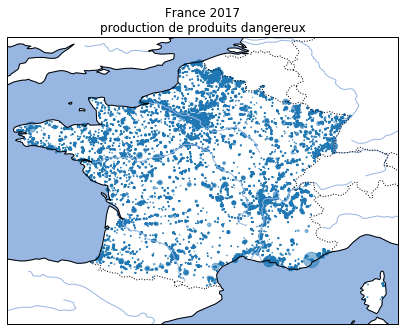

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent(lim_metropole)
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':')
ax.scatter(ets17_2_metro.LLX, ets17_2_metro.LLY,
           s=ets17_2_metro.Quantite ** 0.5 / 5, alpha=0.5)
ax.set_title('France 2017\nproduction de produits dangereux');